# Decision Modeling Mini Sprint
This is a notebook to document the Decision Modeling Mini Sprint from IBM Skills Build. It is a 3-week sprint where we will analyze Formula 1 race data and build a decision model. To get started running this notebook, You can install the requirements by following the instructions in the [README.md](../README.md) file in the root of this repository.

## Problem Statement
We have been tasked with analyzing the data to make predictions on which constructor will win a head-to-head matchup on a specific circuit. We will use the data provided to build a decision model that will predict the points that each constructor will score in a head-to-head matchup on a specific circuit.

In [3]:
# Set the path for our data
data_path = './data/decision-modeling-sprint/'

In [4]:
# Unzip The data into the data path specified
zip_file = 'data.zip'
!unzip -o {data_path + zip_file} -d {data_path}

Archive:  ./data/decision-modeling-sprint/data.zip
  inflating: ./data/decision-modeling-sprint/f1db-seasons-constructor-standings.csv  
  inflating: ./data/decision-modeling-sprint/f1db-countries.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-constructor-standings.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-race-results.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-sprint-race-results.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-starting-grid-positions.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-pre-qualifying-results.csv  
  inflating: ./data/decision-modeling-sprint/f1db-constructors.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-qualifying-results.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-pit-stops.csv  
  inflating: ./data/decision-modeling-sprint/f1db-engine-manufacturers.csv  
  inflating: ./data/decision-modeling-sprint/f1db-races-sprint-qualifying-results.csv 

In [5]:
# Here we import all our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api import types
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Cleaning and Preprocessing
In this section we will load the data into pandas data frames And cleaned the data to make it ready for analysis. We will specifically be looking at data related to constructors and their performance on circuits.

In [6]:
drivers = pd.read_csv(data_path + 'f1db-drivers.csv').replace('\\N', np.nan)
constructors = pd.read_csv(data_path + 'f1db-constructors.csv').replace('\\N', np.nan)
races = pd.read_csv(data_path + 'f1db-races.csv').replace('\\N', np.nan)
circuits = pd.read_csv(data_path + 'f1db-circuits.csv').replace('\\N', np.nan)
constructor_standings = pd.read_csv(data_path + 'f1db-races-constructor-standings.csv').replace('\\N', np.nan)
qualifying = pd.read_csv(data_path + 'f1db-races-qualifying-results.csv').replace('\\N', np.nan)
results = pd.read_csv(data_path + 'f1db-races-race-results.csv').replace('\\N', np.nan)
pit_stops = pd.read_csv(data_path + 'f1db-races-pit-stops.csv').replace('\\N', np.nan)

In [7]:
constructors.info()
constructors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        183 non-null    object 
 1   name                      183 non-null    object 
 2   fullName                  183 non-null    object 
 3   countryId                 183 non-null    object 
 4   bestChampionshipPosition  76 non-null     float64
 5   bestStartingGridPosition  172 non-null    float64
 6   bestRaceResult            153 non-null    float64
 7   totalChampionshipWins     183 non-null    int64  
 8   totalRaceEntries          183 non-null    int64  
 9   totalRaceStarts           183 non-null    int64  
 10  totalRaceWins             183 non-null    int64  
 11  total1And2Finishes        183 non-null    int64  
 12  totalRaceLaps             183 non-null    int64  
 13  totalPodiums              183 non-null    int64  
 14  totalPodiu

,id,name,fullName,countryId,bestChampionshipPosition,bestStartingGridPosition,bestRaceResult,totalChampionshipWins,totalRaceEntries,totalRaceStarts,totalRaceWins,total1And2Finishes,totalRaceLaps,totalPodiums,totalPodiumRaces,totalChampionshipPoints,totalPolePositions,totalFastestLaps
0,adams,Adams,Adams,united-states-of-america,NaN,17.0,27.0,0,1,1,0,0,108,0,0,0.0,0,0
1,afm,AFM,Alex von Falkenhausen Motorenbau,germany,NaN,9.0,9.0,0,4,4,0,0,98,0,0,0.0,0,0
2,ags,AGS,Automobiles Gonfaronnaises Sportives,france,11.0,10.0,6.0,0,80,48,0,0,2031,0,0,2.0,0,0
3,alfa-romeo,Alfa Romeo,Alfa Romeo Racing,italy,6.0,1.0,1.0,0,214,214,10,4,20608,26,18,199.0,12,16
4,alfa-special,Alfa Special,Alfa Special,south-africa,NaN,16.0,10.0,0,2,2,0,0,132,0,0,0.0,0,0


In [8]:
constructor_standings.info()
constructor_standings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10089 entries, 0 to 10088
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raceId                10089 non-null  int64  
 1   year                  10089 non-null  int64  
 2   round                 10089 non-null  int64  
 3   positionDisplayOrder  10089 non-null  int64  
 4   positionNumber        10072 non-null  float64
 5   positionText          10089 non-null  object 
 6   constructorId         10089 non-null  object 
 7   engineManufacturerId  10089 non-null  object 
 8   points                10089 non-null  float64
 9   positionsGained       9655 non-null   float64
dtypes: float64(3), int64(4), object(3)
memory usage: 788.3+ KB


,raceId,year,round,positionDisplayOrder,positionNumber,positionText,constructorId,engineManufacturerId,points,positionsGained
0,65,1958,1,1,1.0,1,cooper,climax,8.0,NaN
1,65,1958,1,2,2.0,2,ferrari,ferrari,6.0,NaN
2,65,1958,1,3,3.0,3,maserati,maserati,3.0,NaN
3,66,1958,2,1,1.0,1,cooper,climax,16.0,0.0
4,66,1958,2,2,2.0,2,ferrari,ferrari,12.0,0.0


In [9]:
display(races.head(), circuits.head())

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,circuitType,courseLength,laps,distance,scheduledLaps,scheduledDistance,preQualifyingDate,preQualifyingTime,freePractice1Date,freePractice1Time,freePractice2Date,freePractice2Time,freePractice3Date,freePractice3Time,freePractice4Date,freePractice4Time,qualifying1Date,qualifying1Time,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
0,1,1950,1,1950-05-13,NaN,great-britain,1950 RAC British Grand Prix,TWO_SESSION,NaN,silverstone,RACE,4.649,70,325.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1950,2,1950-05-21,NaN,monaco,Grand Prix de Monaco 1950,TWO_SESSION,NaN,monaco,STREET,3.181,100,318.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1950,3,1950-05-30,NaN,indianapolis,1950 Indianapolis 500,FOUR_LAPS,NaN,indianapolis,RACE,4.023,138,555.224,200.0,804.672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1950,4,1950-06-04,NaN,switzerland,Grosser Preis der Schweiz 1950,TWO_SESSION,NaN,bremgarten,ROAD,7.280,42,305.760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1950,5,1950-06-18,NaN,belgium,1950 Belgian Grand Prix,TWO_SESSION,NaN,spa-francorchamps,ROAD,14.120,35,494.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,name,fullName,previousNames,type,placeName,countryId,latitude,longitude,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,Adelaide,australia,-34.927222,138.617222,11
1,aida,Aida,Okayama International Circuit,TI Circuit Aida,RACE,Aida,japan,34.915000,134.221111,2
2,ain-diab,Ain-Diab,Ain-Diab Circuit,NaN,ROAD,Casablanca,morocco,33.578611,-7.687500,1
3,aintree,Aintree,Aintree Motor Racing Circuit,NaN,ROAD,Aintree,united-kingdom,53.476944,-2.940556,5
4,anderstorp,Anderstorp Raceway,Anderstorp Raceway,Scandinavian Raceway,RACE,Anderstorp,sweden,57.264167,13.601389,6


### Race Data
The race data contains information about the circuit type, circuit length, qualifying format, and round. We're going to add that data to our main data set For analysis and training.

In [10]:
races.rename(columns={'id': 'raceId'}, inplace=True)
constructor_data  = constructor_standings.merge(races[['raceId', 'round', 'year', 'officialName', 'circuitType', 'courseLength', 'qualifyingFormat']], on=['raceId', 'round', 'year'])
constructor_data .rename(columns={'round': 'raceInSeason', 'points': 'cumulativePoints', 'positionDisplayOrder':'endPosition'}, inplace=True)
constructor_data .sort_values(by=['year', 'raceInSeason', 'cumulativePoints'], ascending=False, inplace=True)
constructor_data .head()

,raceId,year,raceInSeason,endPosition,positionNumber,positionText,constructorId,engineManufacturerId,cumulativePoints,positionsGained,officialName,circuitType,courseLength,qualifyingFormat
10079,1109,2024,8,1,1.0,1,red-bull,honda-rbpt,276.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10080,1109,2024,8,2,2.0,2,ferrari,ferrari,252.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10081,1109,2024,8,3,3.0,3,mclaren,mercedes,184.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10082,1109,2024,8,4,4.0,4,mercedes,mercedes,96.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10083,1109,2024,8,5,5.0,5,aston-martin,mercedes,44.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT


In [11]:
results.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,sharedCar,laps,time,timeMillis,timePenalty,timePenaltyMillis,gap,gapMillis,gapLaps,interval,intervalMillis,reasonRetired,points,gridPositionNumber,gridPositionText,positionsGained,fastestLap,pitStops,driverOfTheDay,grandSlam
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,pirelli,False,70.0,2:13:23.600,8003600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,1.0,1,0.0,True,NaN,NaN,False
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,pirelli,False,70.0,2:13:26.200,8006200.0,NaN,NaN,+2.600,2600.0,NaN,+2.600,2600.0,NaN,6.0,2.0,2,0.0,False,NaN,NaN,False
2,1,1950,1,3,3.0,3,4,reg-parnell,alfa-romeo,alfa-romeo,pirelli,False,70.0,2:14:15.600,8055600.0,NaN,NaN,+52.000,52000.0,NaN,+49.400,49400.0,NaN,4.0,4.0,4,1.0,False,NaN,NaN,False
3,1,1950,1,4,4.0,4,14,yves-giraud-cabantous,talbot-lago,talbot-lago,dunlop,False,68.0,NaN,NaN,NaN,NaN,+2 laps,NaN,2.0,NaN,NaN,NaN,3.0,6.0,6,2.0,False,NaN,NaN,False
4,1,1950,1,5,5.0,5,15,louis-rosier,talbot-lago,talbot-lago,dunlop,False,68.0,NaN,NaN,NaN,NaN,+2 laps,NaN,2.0,NaN,NaN,NaN,2.0,9.0,9,4.0,False,NaN,NaN,False


In [12]:
results[['gridPositionNumber', 'gridPositionText']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26491 entries, 0 to 26490
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gridPositionNumber  24545 non-null  float64
 1   gridPositionText    24721 non-null  object 
dtypes: float64(1), object(1)
memory usage: 414.0+ KB


### Results Data
From the results data we can get information about how many points each constructor scored in each race.This will work as the label for our training data. We will also take the grid position, or a starting position, as a feature for our model.

In [13]:
most_points = results.groupby(['raceId', 'constructorId'])['points'].sum().reset_index()
most_points.head(15)

,raceId,constructorId,points
0,1,alfa-romeo,19.0
1,1,alta,0.0
2,1,era,0.0
3,1,maserati,0.0
4,1,talbot-lago,5.0
5,2,alfa-romeo,9.0
6,2,cooper,0.0
7,2,era,0.0
8,2,ferrari,9.0
9,2,maserati,6.0


In [14]:
best_grid = results.groupby(['raceId', 'constructorId'])['gridPositionNumber'].min().reset_index()
best_grid[best_grid['gridPositionNumber'].isnull()].head()

,raceId,constructorId,gridPositionNumber
135,20,aston-butterworth,NaN
153,21,krakau,NaN
166,23,aston-butterworth,NaN
167,23,cisitalia,NaN
172,23,hwm,NaN


In [15]:
constructor_data = constructor_data.merge(most_points, on=['raceId', 'constructorId'])
constructor_data = constructor_data.merge(best_grid, on=['raceId', 'constructorId'])
constructor_data.rename(columns={'points': 'racePoints', 'gridPositionNumber': 'bestStartPosition'}, inplace=True)
constructor_data.head(10)

,raceId,year,raceInSeason,endPosition,positionNumber,positionText,constructorId,engineManufacturerId,cumulativePoints,positionsGained,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition
0,1109,2024,8,1,1.0,1,red-bull,honda-rbpt,276.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0
1,1109,2024,8,2,2.0,2,ferrari,ferrari,252.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0
2,1109,2024,8,3,3.0,3,mclaren,mercedes,184.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0
3,1109,2024,8,4,4.0,4,mercedes,mercedes,96.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0
4,1109,2024,8,5,5.0,5,aston-martin,mercedes,44.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0
5,1109,2024,8,6,6.0,6,rb,honda-rbpt,24.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,4.0,8.0
6,1109,2024,8,7,7.0,7,haas,ferrari,7.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,19.0
7,1109,2024,8,8,8.0,8,williams,mercedes,2.0,1.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,2.0,9.0
8,1109,2024,8,9,9.0,9,alpine,renault,2.0,-1.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,1.0,10.0
9,1109,2024,8,10,10.0,10,kick-sauber,ferrari,0.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,17.0


In [16]:
# Dropping columns that are not needed
constructor_data.drop(columns=['positionNumber', 'positionText', 'endPosition', 'positionsGained'], inplace=True)
constructor_data.head()

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition
0,1109,2024,8,red-bull,honda-rbpt,276.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0
1,1109,2024,8,ferrari,ferrari,252.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0
2,1109,2024,8,mclaren,mercedes,184.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0
3,1109,2024,8,mercedes,mercedes,96.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0
4,1109,2024,8,aston-martin,mercedes,44.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0


### Pit stops Data
Here we are just taking the total Pit stop time For each constructorin a race.

In [17]:
pit_stops.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,stop,lap,time,timeMillis
0,550,1994,2,1,1,1,20,erik-comas,larrousse,ford,goodyear,1,1,49.111,49111.0
1,550,1994,2,2,2,2,3,ukyo-katayama,tyrrell,yamaha,goodyear,1,17,28.482,28482.0
2,550,1994,2,3,3,3,7,mika-hakkinen,mclaren,peugeot,goodyear,1,18,43.745,43745.0
3,550,1994,2,4,4,4,0,damon-hill,williams,renault,goodyear,1,18,21.992,21992.0
4,550,1994,2,5,5,5,24,michele-alboreto,minardi,ford,goodyear,1,19,27.693,27693.0


In [18]:
constructor_pit_stop_time = pit_stops.groupby(['raceId', 'constructorId'])['timeMillis'].sum().reset_index()
constructor_pit_stop_time.head()

,raceId,constructorId,timeMillis
0,550,benetton,96058.0
1,550,ferrari,47400.0
2,550,footwork,135223.0
3,550,jordan,87552.0
4,550,larrousse,72952.0


In [19]:
constructor_data = constructor_data.merge(constructor_pit_stop_time, on=['raceId', 'constructorId'])
constructor_data.rename(columns={'timeMillis': 'totalPitStopTime'}, inplace=True)
constructor_data.head(10)

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition,totalPitStopTime
0,1109,2024,8,red-bull,honda-rbpt,276.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0,2396483.0
1,1109,2024,8,ferrari,ferrari,252.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0,4685098.0
2,1109,2024,8,mclaren,mercedes,184.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0,4723183.0
3,1109,2024,8,mercedes,mercedes,96.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0,4768964.0
4,1109,2024,8,aston-martin,mercedes,44.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0,4825398.0
5,1109,2024,8,rb,honda-rbpt,24.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,4.0,8.0,4763387.0
6,1109,2024,8,williams,mercedes,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,2.0,9.0,4797374.0
7,1109,2024,8,alpine,renault,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,1.0,10.0,2381893.0
8,1109,2024,8,kick-sauber,ferrari,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,17.0,4829073.0
9,1108,2024,7,red-bull,honda-rbpt,268.0,Formula 1 MSC Cruises Gran Premio dell'Emilia ...,RACE,4.909,KNOCKOUT,29.0,1.0,60085.0


### Qualifying Data
Here we take the average of the best qualifying time for each constructor per race.

In [20]:
qualifying.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,time,timeMillis,q1,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,pirelli,1:50.800,110800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,pirelli,1:51.000,111000.0,NaN,NaN,NaN,NaN,NaN,NaN,+0.200,200.0,+0.200,200.0,NaN
2,1,1950,1,3,3.0,3,1,juan-manuel-fangio,alfa-romeo,alfa-romeo,pirelli,1:51.000,111000.0,NaN,NaN,NaN,NaN,NaN,NaN,+0.200,200.0,+0.000,0.0,NaN
3,1,1950,1,4,4.0,4,4,reg-parnell,alfa-romeo,alfa-romeo,pirelli,1:52.200,112200.0,NaN,NaN,NaN,NaN,NaN,NaN,+1.400,1400.0,+1.200,1200.0,NaN
4,1,1950,1,5,5.0,5,21,birabongse-bhanudej,maserati,maserati,pirelli,1:52.600,112600.0,NaN,NaN,NaN,NaN,NaN,NaN,+1.800,1800.0,+0.400,400.0,NaN


In [21]:
min_qualifying_1 = qualifying.groupby(['raceId', 'constructorId'])['q1Millis'].min().reset_index()
min_qualifying_2 = qualifying.groupby(['raceId', 'constructorId'])['q2Millis'].min().reset_index()
min_qualifying_3 = qualifying.groupby(['raceId', 'constructorId'])['q3Millis'].min().reset_index()
min_qualifying = min_qualifying_1.merge(min_qualifying_2, on=['raceId', 'constructorId']).merge(min_qualifying_3, on=['raceId', 'constructorId'])
min_qualifying.sort_values(by=['raceId', 'q1Millis', 'q2Millis', 'q3Millis'], ascending=False, inplace=True)

def get_qualifying_time(row):
    divisor = 3
    q1, q2, q3 = row['q1Millis'], row['q2Millis'], row['q3Millis']
    if pd.isnull(q1):
        q1 = 0
        divisor -= 1
    if pd.isnull(q2):
        q2 = 0
        divisor -= 1
    if pd.isnull(q3):
        q3 = 0
        divisor -= 1
    if divisor == 0:
        return np.nan
    return (q1 + q2 + q3) / divisor
min_qualifying['averageQualifyingTime'] = min_qualifying.apply(get_qualifying_time, axis=1)
min_qualifying.head()

,raceId,constructorId,q1Millis,q2Millis,q3Millis,averageQualifyingTime
12485,1109,kick-sauber,72512.0,NaN,NaN,72512.000000
12484,1109,haas,71832.0,71440.0,NaN,71636.000000
12488,1109,rb,71785.0,71106.0,70858.0,71249.666667
12482,1109,aston-martin,71728.0,71563.0,NaN,71645.500000
12481,1109,alpine,71714.0,70896.0,71311.0,71307.000000


In [22]:
constructor_data = constructor_data.merge(min_qualifying[['raceId', 'constructorId', 'averageQualifyingTime']], on=['raceId', 'constructorId'])
constructor_data.head(10)

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime
0,1109,2024,8,red-bull,honda-rbpt,276.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0,2396483.0,71007.666667
1,1109,2024,8,ferrari,ferrari,252.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0,4685098.0,70879.333333
2,1109,2024,8,mclaren,mercedes,184.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0,4723183.0,70885.333333
3,1109,2024,8,mercedes,mercedes,96.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0,4768964.0,70988.000000
4,1109,2024,8,aston-martin,mercedes,44.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0,4825398.0,71645.500000
5,1109,2024,8,rb,honda-rbpt,24.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,4.0,8.0,4763387.0,71249.666667
6,1109,2024,8,williams,mercedes,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,2.0,9.0,4797374.0,71262.333333
7,1109,2024,8,alpine,renault,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,1.0,10.0,2381893.0,71307.000000
8,1109,2024,8,kick-sauber,ferrari,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,17.0,4829073.0,72512.000000
9,1108,2024,7,red-bull,honda-rbpt,268.0,Formula 1 MSC Cruises Gran Premio dell'Emilia ...,RACE,4.909,KNOCKOUT,29.0,1.0,60085.0,75228.000000


Here we are limiting our data set to the last 14 years of data to make the model more relevant to the current state of Formula 1 racing. It also had the effect of eliminating some of the data cleaning that would have been necessary if we had used the entire data set.

In [23]:
constructor_data = constructor_data[constructor_data['year'] >= 2010]

In [24]:
constructor_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3006 entries, 0 to 3005
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raceId                 3006 non-null   int64  
 1   year                   3006 non-null   int64  
 2   raceInSeason           3006 non-null   int64  
 3   constructorId          3006 non-null   object 
 4   engineManufacturerId   3006 non-null   object 
 5   cumulativePoints       3006 non-null   float64
 6   officialName           3006 non-null   object 
 7   circuitType            3006 non-null   object 
 8   courseLength           3006 non-null   float64
 9   qualifyingFormat       3006 non-null   object 
 10  racePoints             3006 non-null   float64
 11  bestStartPosition      2998 non-null   float64
 12  totalPitStopTime       3006 non-null   float64
 13  averageQualifyingTime  3006 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 352.3+ KB


In [25]:
constructor_data[constructor_data['bestStartPosition'].isnull()]

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime
123,1097,2023,18,aston-martin,mercedes,236.0,Formula 1 Lenovo United States Grand Prix 2023,RACE,5.513,KNOCKOUT,6.0,NaN,98290.0,96268.0
127,1097,2023,18,haas,ferrari,12.0,Formula 1 Lenovo United States Grand Prix 2023,RACE,5.513,KNOCKOUT,0.0,NaN,100693.0,95944.5
474,1062,2022,5,aston-martin,mercedes,6.0,Formula 1 Crypto.com Miami Grand Prix 2022,STREET,5.410,KNOCKOUT,1.0,NaN,38935.0,90371.0
764,1032,2020,14,williams,mercedes,0.0,Formula 1 DHL Turkish Grand Prix 2020,RACE,5.338,KNOCKOUT,0.0,NaN,106917.0,130017.0
873,1021,2020,3,haas,ferrari,1.0,Formula 1 Aramco Magyar Nagydíj 2020,RACE,4.381,KNOCKOUT,1.0,NaN,46212.0,76152.0
1223,986,2018,10,williams,mercedes,4.0,Formula 1 2018 Rolex British Grand Prix,RACE,5.891,KNOCKOUT,0.0,NaN,55998.0,89252.0
1927,916,2014,19,red-bull,renault,405.0,2014 Formula 1 Etihad Airways Abu Dhabi Grand ...,RACE,5.554,KNOCKOUT,32.0,NaN,88034.0,101721.0
2124,898,2014,1,marussia,ferrari,0.0,2014 Formula 1 Rolex Australian Grand Prix,STREET,5.303,KNOCKOUT,0.0,NaN,94179.0,94293.0


In [26]:
results[(results['raceId'] == 898) & (results['constructorId'] == 'marussia')][['gridPositionNumber', 'gridPositionText']]

,gridPositionNumber,gridPositionText
22195,NaN,PL
22196,NaN,PL


In [27]:
constructor_data.fillna({'bestStartPosition': 21}, inplace=True)
constructor_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3006 entries, 0 to 3005
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raceId                 3006 non-null   int64  
 1   year                   3006 non-null   int64  
 2   raceInSeason           3006 non-null   int64  
 3   constructorId          3006 non-null   object 
 4   engineManufacturerId   3006 non-null   object 
 5   cumulativePoints       3006 non-null   float64
 6   officialName           3006 non-null   object 
 7   circuitType            3006 non-null   object 
 8   courseLength           3006 non-null   float64
 9   qualifyingFormat       3006 non-null   object 
 10  racePoints             3006 non-null   float64
 11  bestStartPosition      3006 non-null   float64
 12  totalPitStopTime       3006 non-null   float64
 13  averageQualifyingTime  3006 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 352.3+ KB


In [28]:
validation_data = constructor_data[constructor_data['year'] == 2024]
analysis_data = constructor_data[constructor_data['year'] < 2024]
training_data = analysis_data.copy()

# Data Analysis


In [29]:
analysis_data.describe()

,raceId,year,raceInSeason,cumulativePoints,courseLength,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime
count,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2.927000e+03,2927.000000
mean,956.415784,2016.428425,10.618039,102.971643,5.176718,9.723266,9.253844,3.012629e+05,88883.439187
std,81.713818,4.084579,5.843919,142.093502,0.803966,12.428192,5.869694,8.739059e+05,12748.072022
min,821.000000,2010.000000,1.000000,0.000000,3.337000,0.000000,1.000000,1.797300e+04,53694.666667
25%,884.000000,2013.000000,6.000000,8.000000,4.381000,0.000000,4.000000,5.542050e+04,78765.166667
50%,954.000000,2016.000000,11.000000,42.000000,5.380000,4.000000,9.000000,8.961500e+04,88619.000000
75%,1027.000000,2020.000000,16.000000,136.000000,5.793000,15.000000,14.000000,1.261580e+05,97481.333333
max,1101.000000,2023.000000,22.000000,860.000000,7.004000,66.000000,23.000000,7.364776e+06,133469.000000


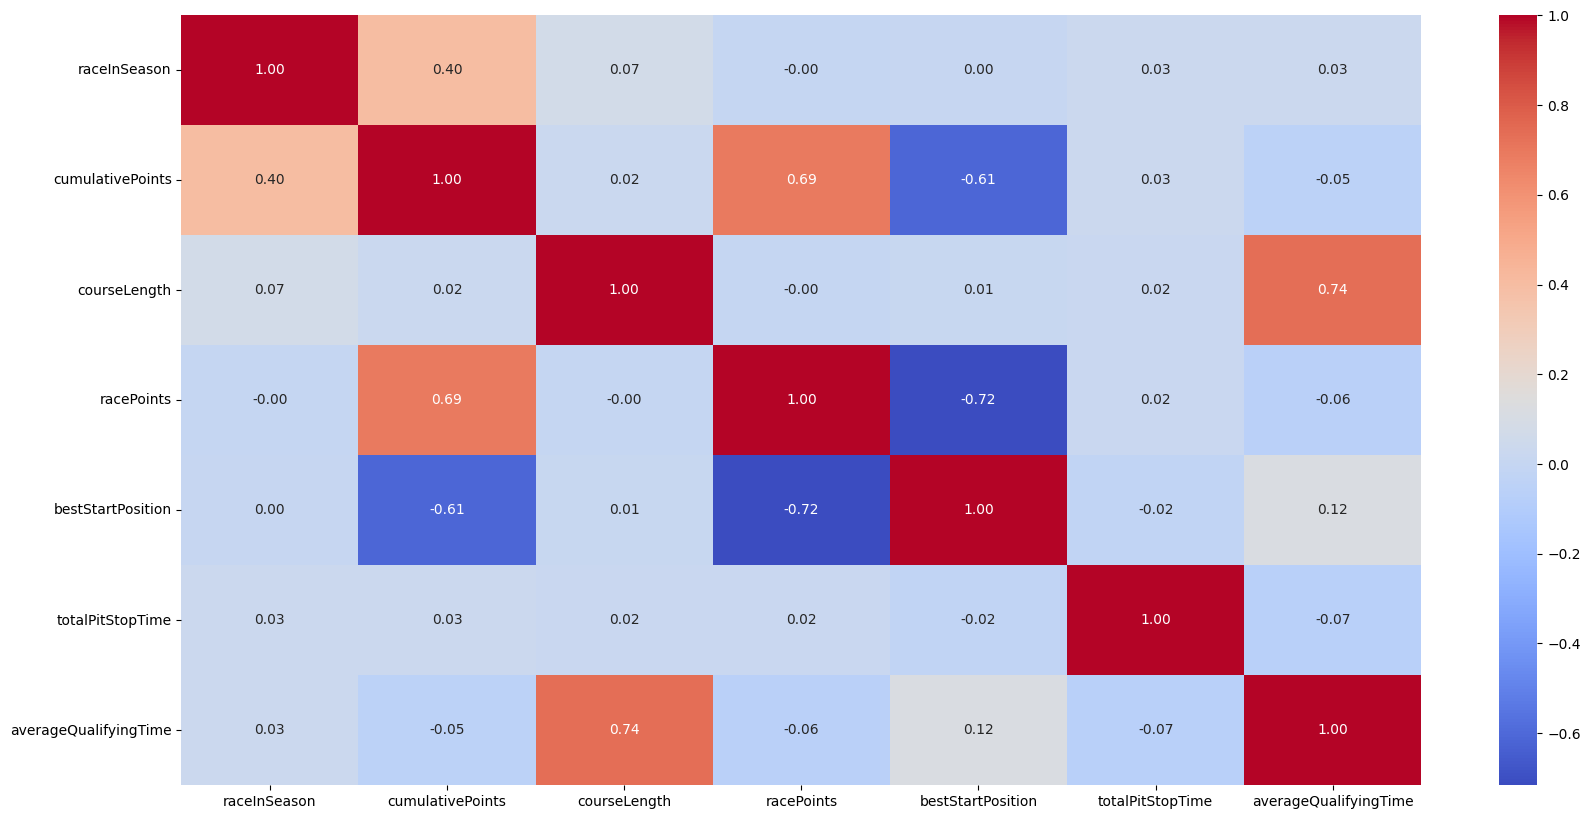

In [30]:
corr = analysis_data.drop(columns=['year', 'constructorId', 'raceId', 'officialName', 'engineManufacturerId', 'qualifyingFormat', 'circuitType']).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.show()

## Different Correlations to Explore

- Correlation between points scored by the constructor and the circuit type
- Correlation between points scored by the constructor and the race number
- Correlation between points scored by the constructor and pit stop time
- Correlation between points scored by the constructor and qualifying time
- Correlation between points scored by the constructor and qualifying format
- Correlation between points scored by the constructor and engine manufacturer
- Correlation between points scored by the constructor and course length

### Correlation between points scored by the constructor and the circuit type

In [31]:
construtors = analysis_data['constructorId'].unique()
len(construtors)

22

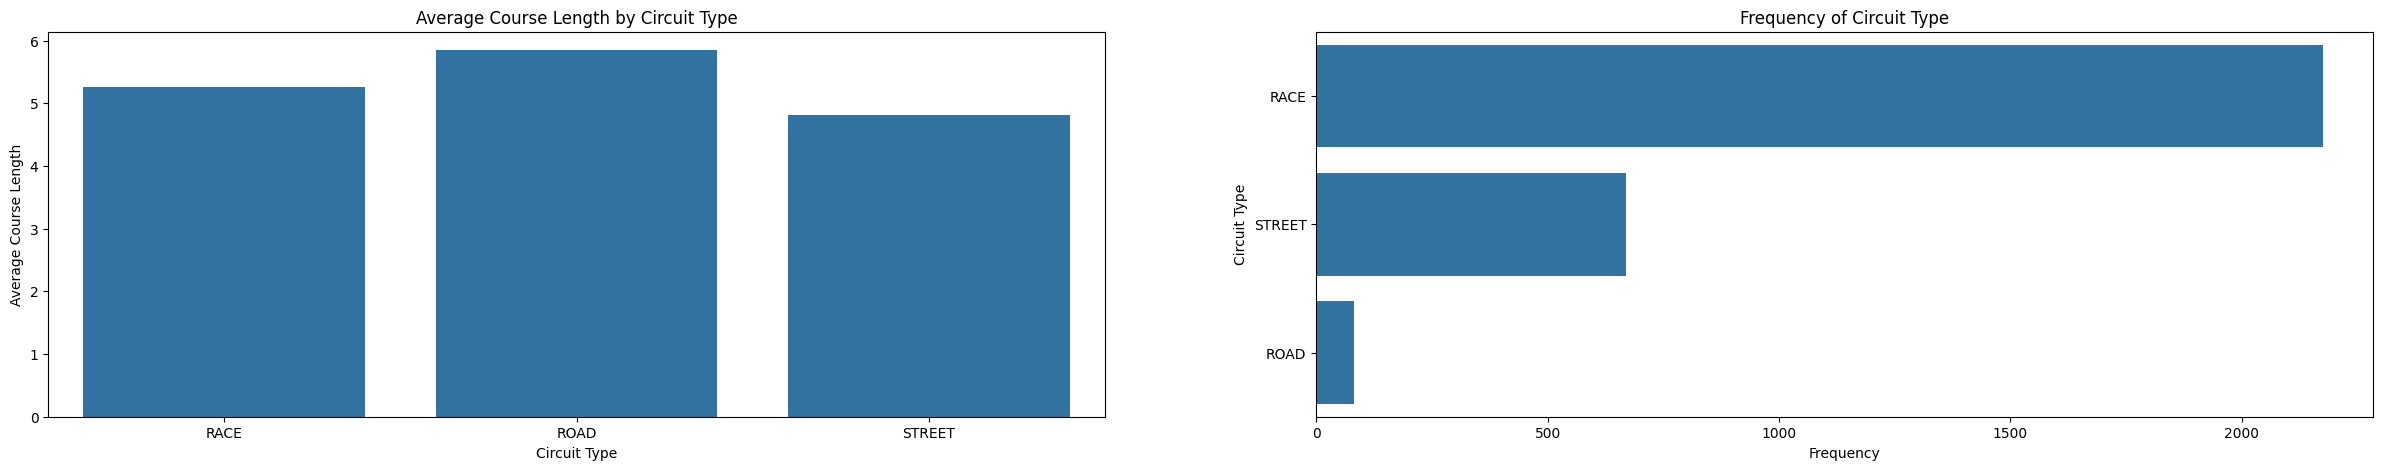

In [32]:
circuit_type_length = analysis_data.groupby('circuitType')['courseLength'].mean().reset_index()
circuit_type_freq = analysis_data['circuitType'].value_counts().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(30, 5))
sns.barplot(data=circuit_type_length, x='circuitType', y='courseLength', ax=ax[0])
ax[0].set_title('Average Course Length by Circuit Type')
ax[0].set_xlabel('Circuit Type')
ax[0].set_ylabel('Average Course Length')

sns.barplot(data=circuit_type_freq, x='count', y='circuitType', ax=ax[1])
ax[1].set_title('Frequency of Circuit Type')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Circuit Type')

plt.show()

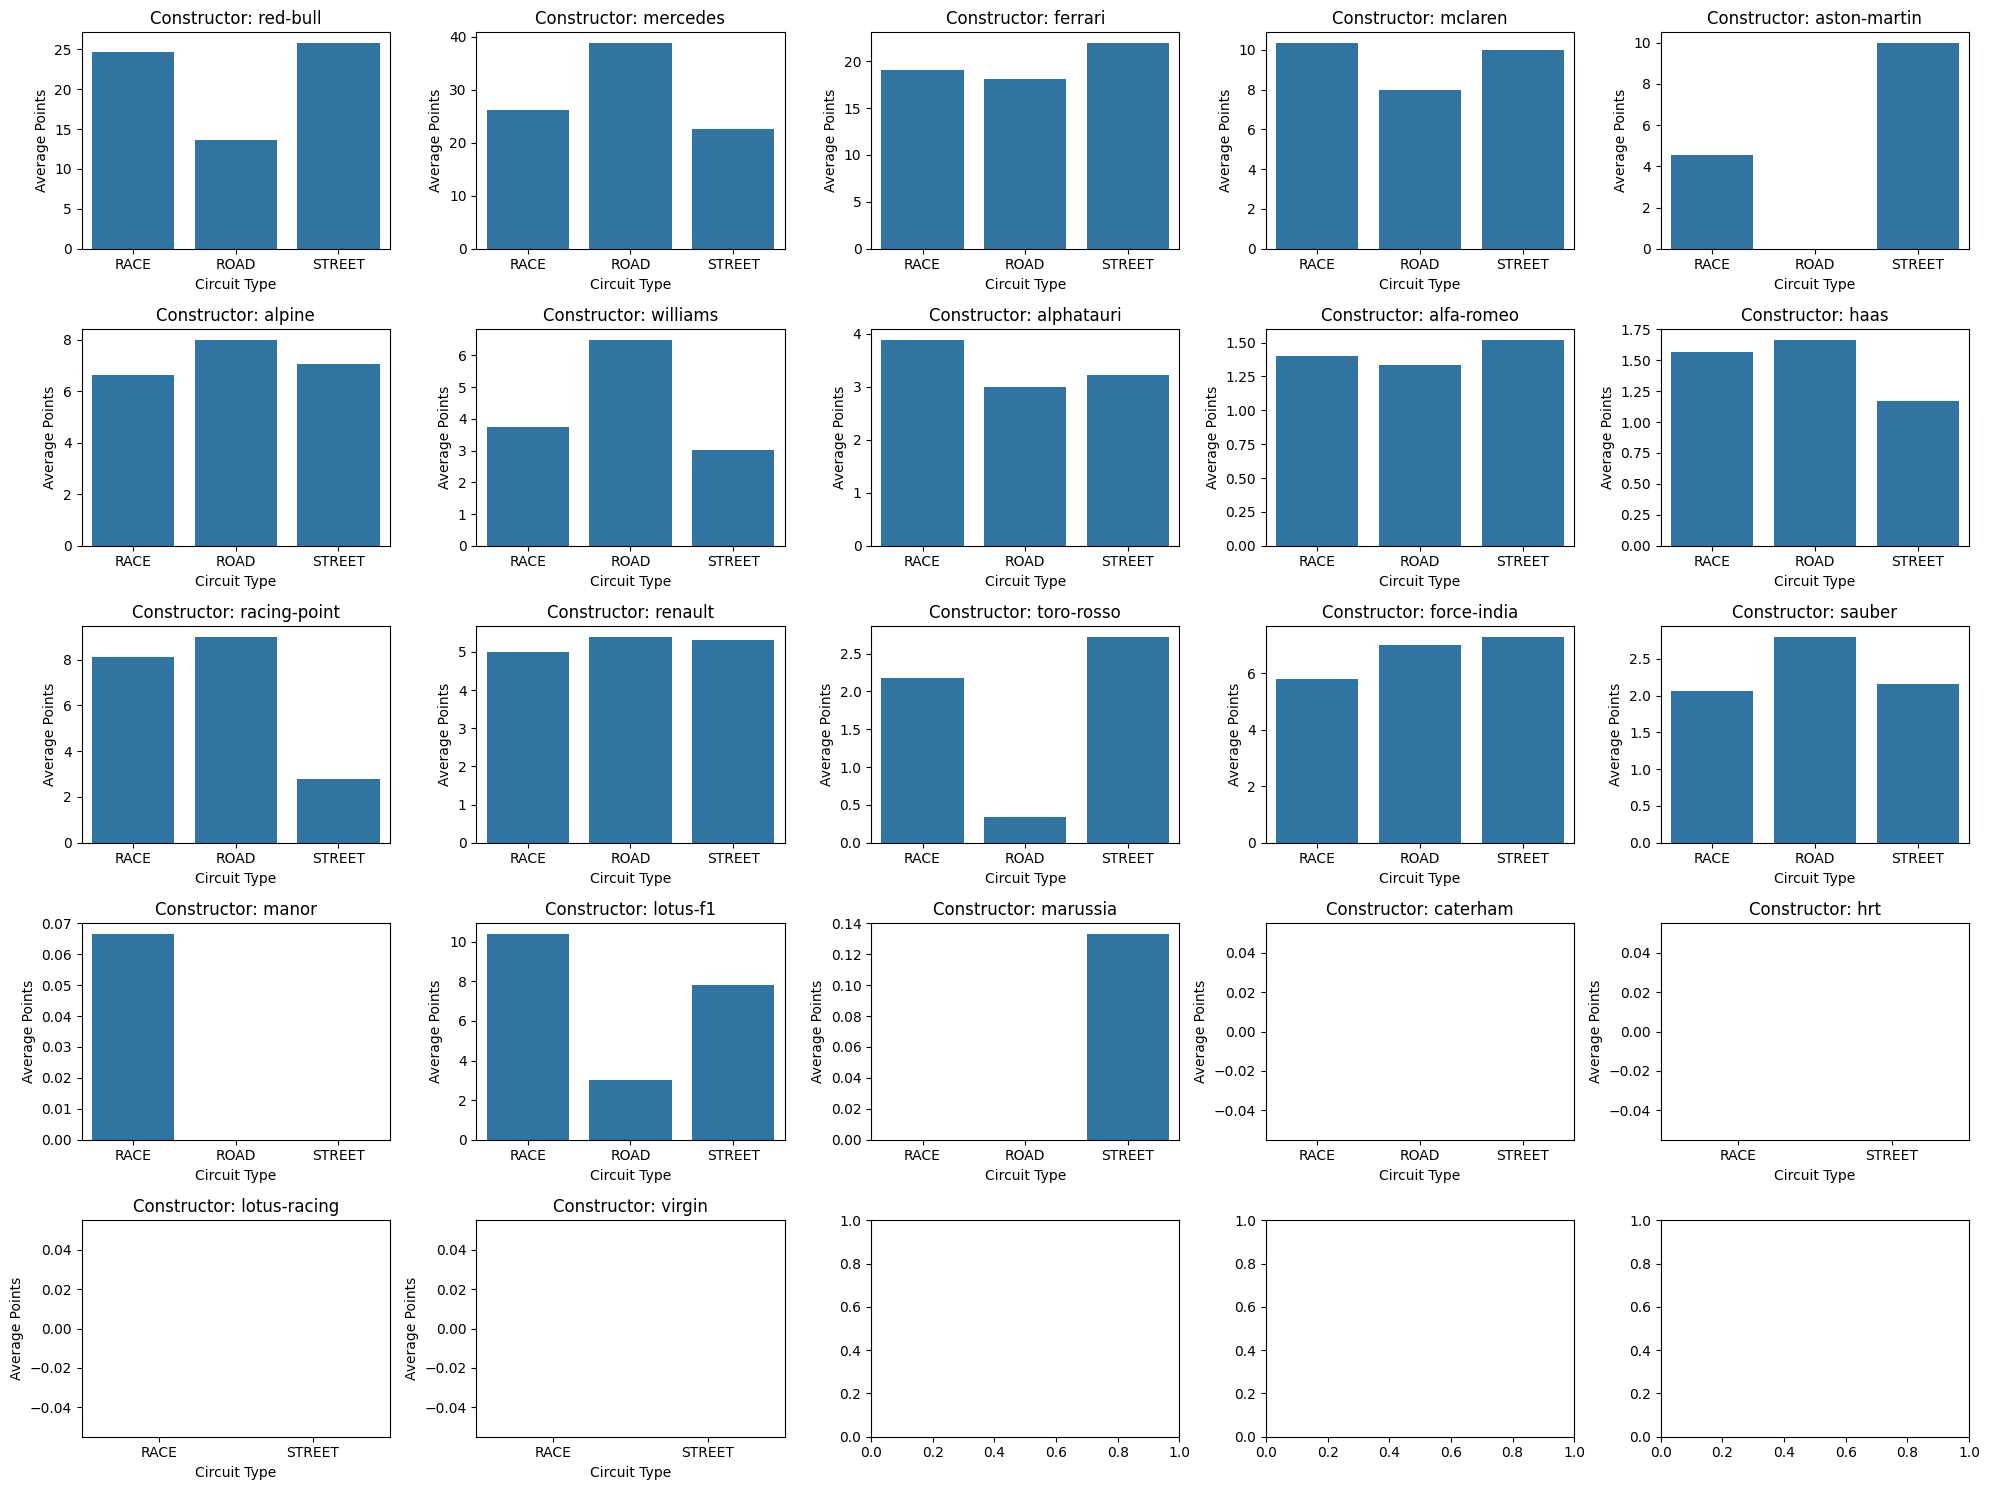

In [33]:
fig, axes = plt.subplots(5, 5, figsize=(20, 15))
circuit_types = analysis_data['circuitType'].unique()
for i in range(len(construtors)):
    constructor = construtors[i]
    row = i // 5
    col = i % 5
    data = analysis_data[analysis_data['constructorId'] == constructor]
    average_points = data.groupby('circuitType')['racePoints'].mean()
    sns.barplot(x=average_points.index, y=average_points, ax=axes[row, col])
    axes[row, col].set_title(f'Constructor: {constructor}')
    axes[row, col].set_xlabel('Circuit Type')
    axes[row, col].set_ylabel('Average Points')
plt.tight_layout()
plt.show()


### Correlation between points scored by the constructor and circuit length

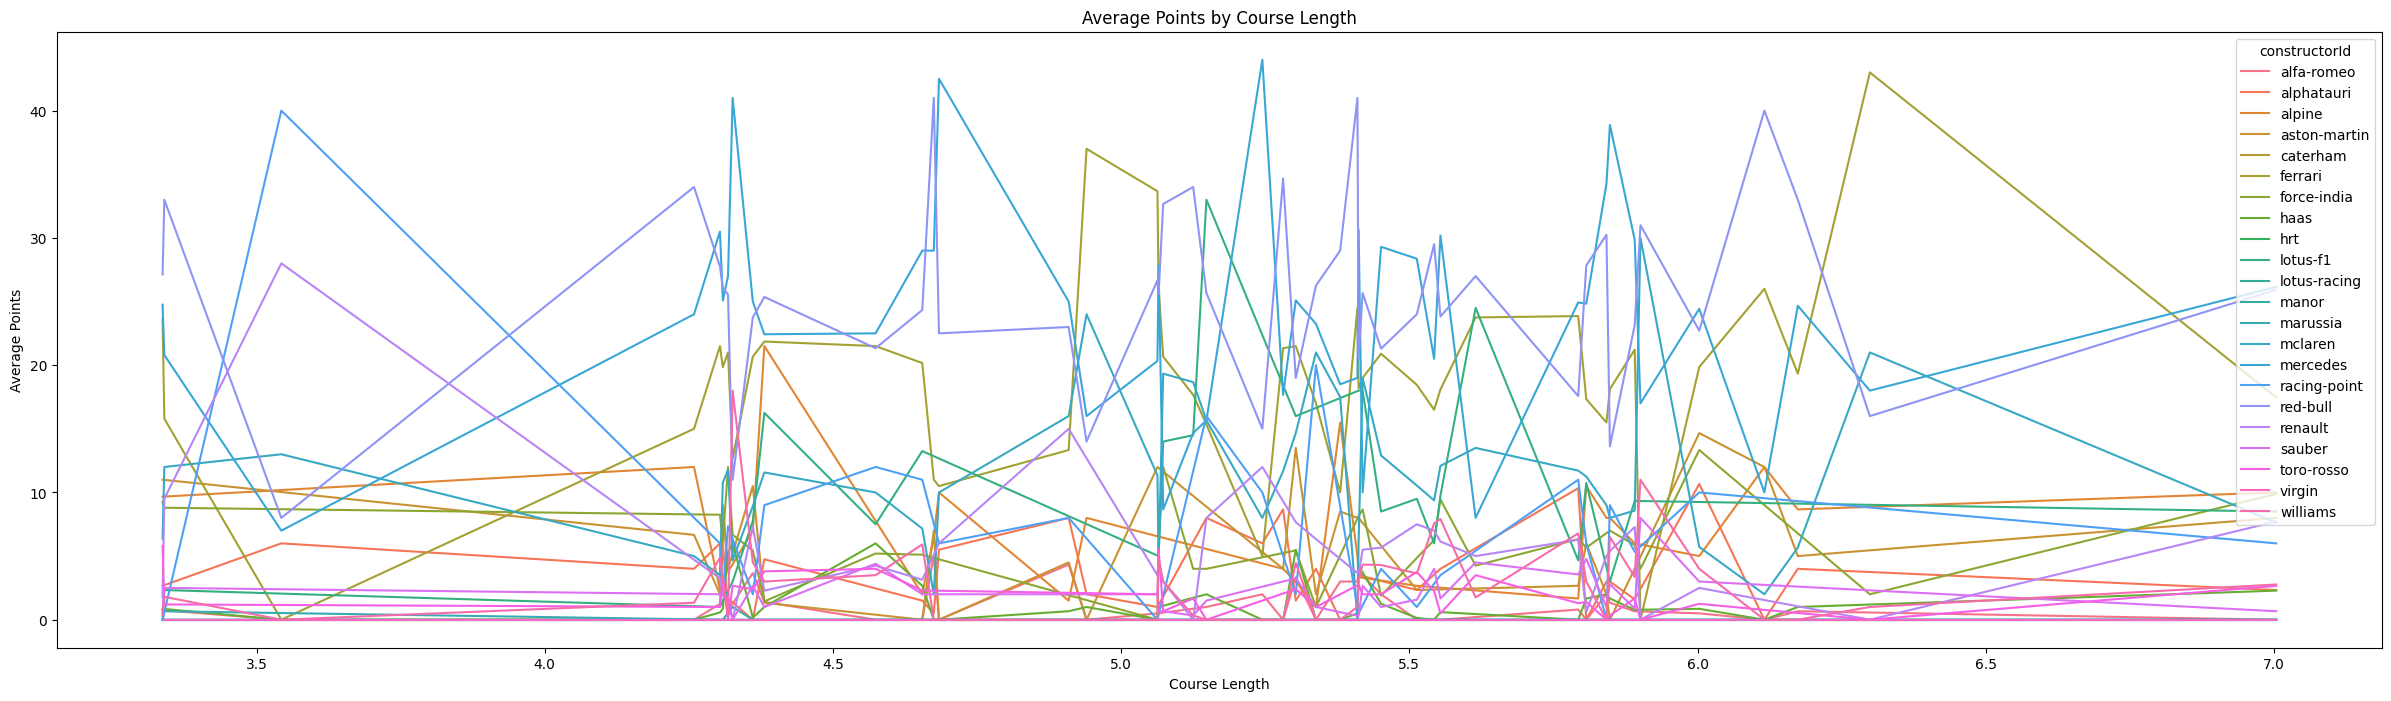

In [34]:
average_points = analysis_data.groupby(['constructorId', 'courseLength'])['racePoints'].mean().reset_index()
plt.figure(figsize=(30, 8))
sns.lineplot(data=average_points, x='courseLength', y='racePoints', hue='constructorId')
plt.title('Average Points by Course Length')
plt.xlabel('Course Length')
plt.ylabel('Average Points')
plt.show()

### Correlation between points scored by the constructor and race number

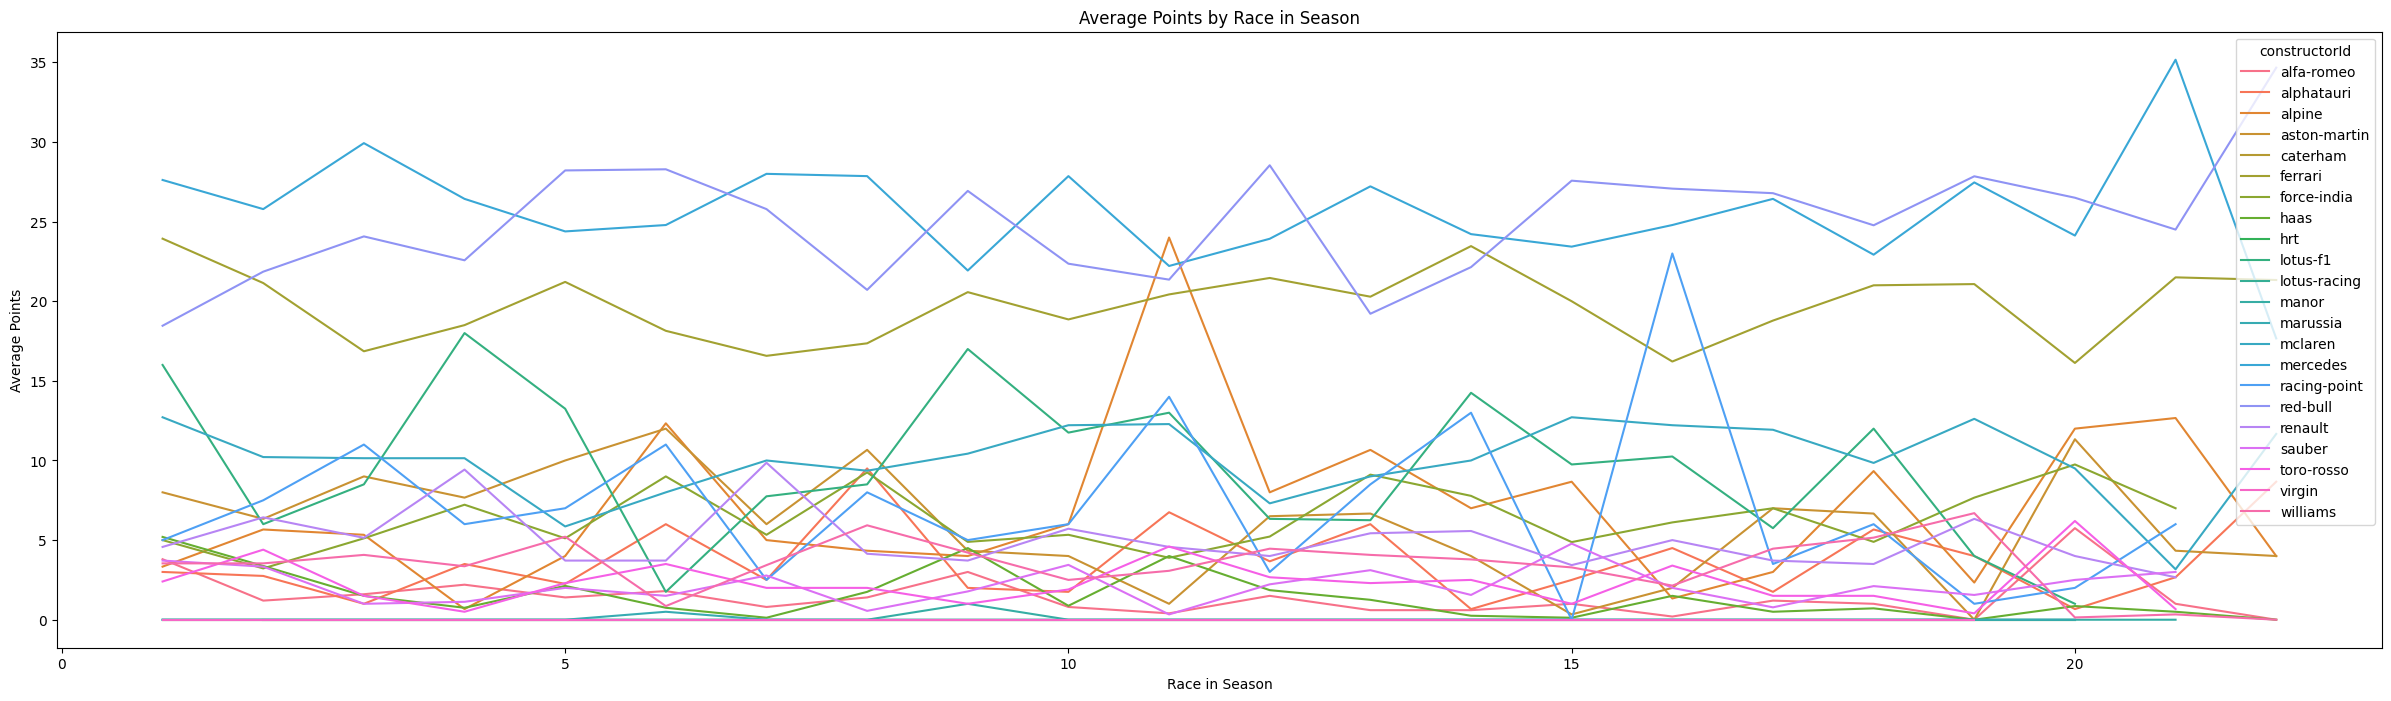

In [35]:
average_points = analysis_data.groupby(['constructorId', 'raceInSeason'])['racePoints'].mean().reset_index()
plt.figure(figsize=(30, 8))
sns.lineplot(data=average_points, x='raceInSeason', y='racePoints', hue='constructorId')
plt.title('Average Points by Race in Season')
plt.xlabel('Race in Season')
plt.ylabel('Average Points')
plt.show()

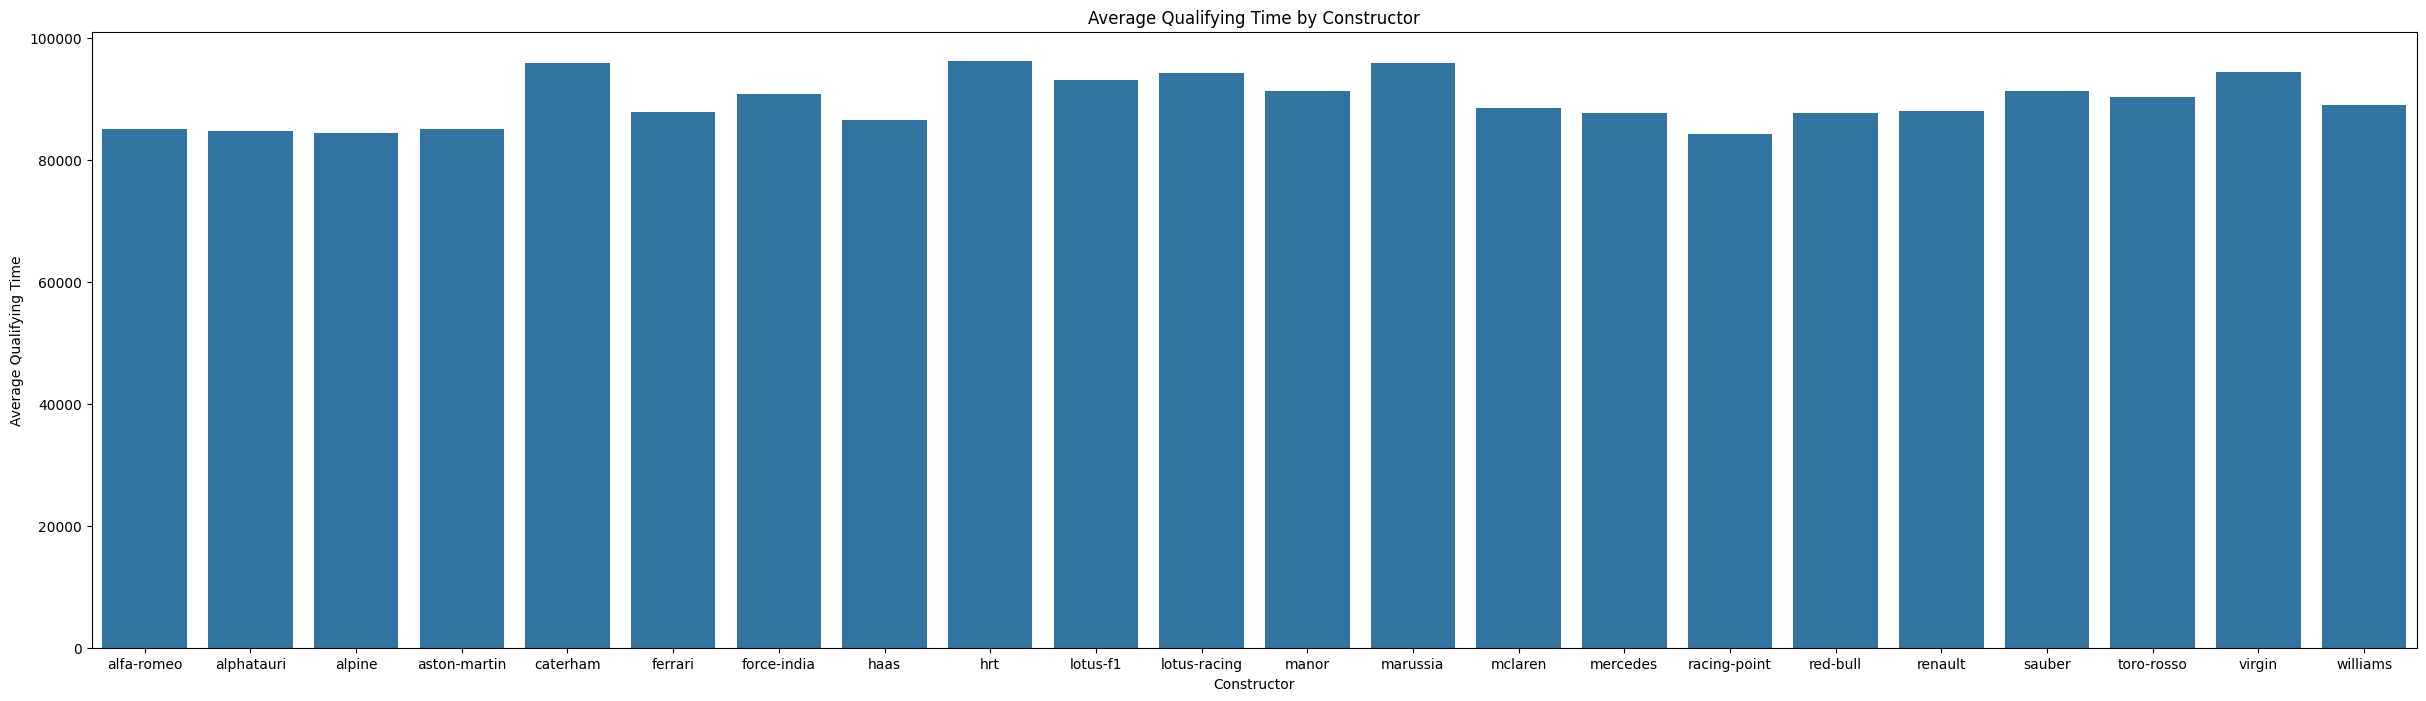

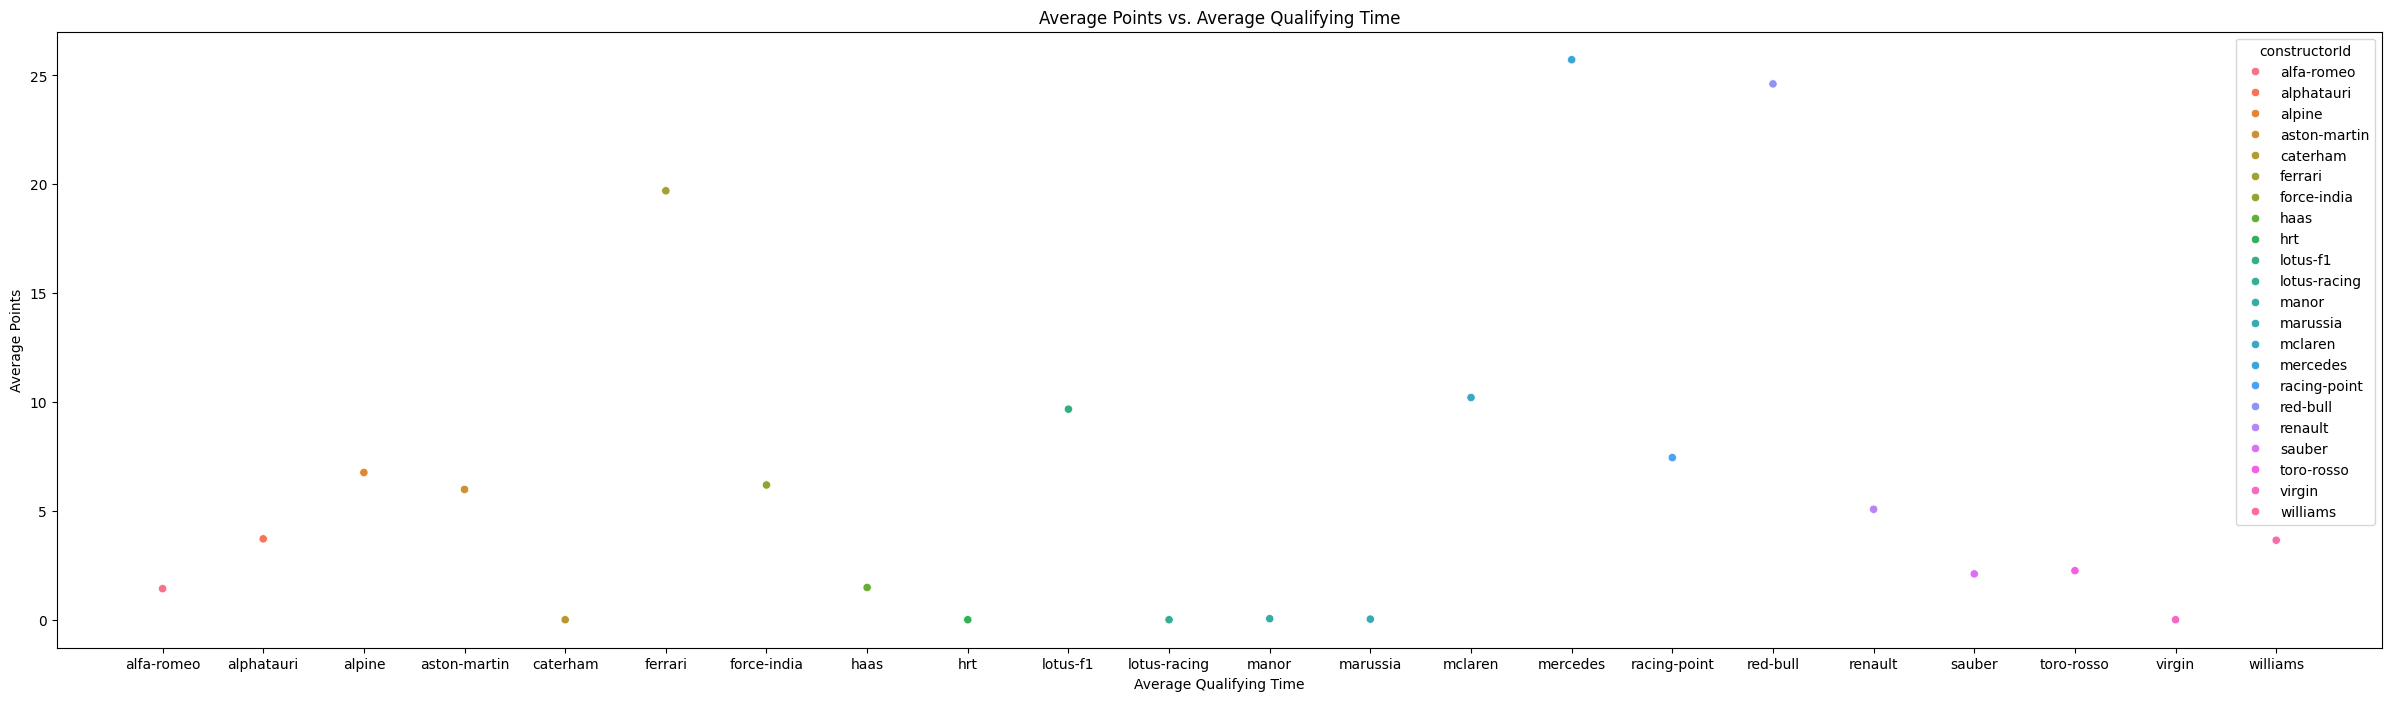

In [45]:
# prompt: generate graphs showing potential correlation relationships between constructor type and average qualifying time

average_qualifying_time = analysis_data.groupby(['constructorId'])['averageQualifyingTime'].mean().reset_index()
plt.figure(figsize=(30, 8))
sns.barplot(data=average_qualifying_time, x='constructorId', y='averageQualifyingTime')
plt.title('Average Qualifying Time by Constructor')
plt.xlabel('Constructor')
plt.ylabel('Average Qualifying Time')
plt.show()

average_points = analysis_data.groupby(['constructorId'])['racePoints'].mean().reset_index()
plt.figure(figsize=(30, 8))
sns.scatterplot(data=average_points, x='constructorId', y='racePoints', hue='constructorId')
plt.title('Average Points vs. Average Qualifying Time')
plt.xlabel('Average Qualifying Time')
plt.ylabel('Average Points')
plt.show()


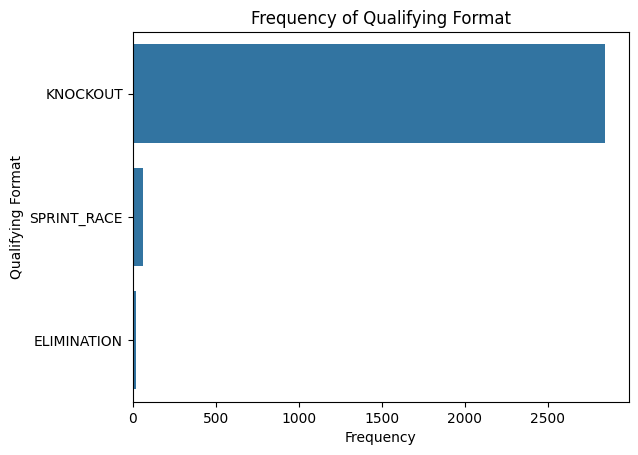

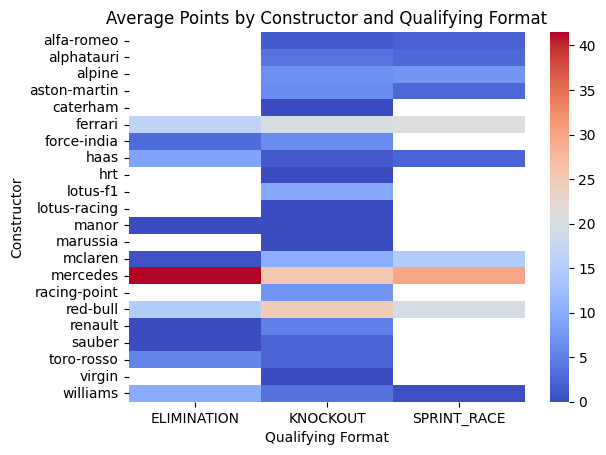

In [49]:
# prompt:  generate graphs showing potential correlation relationships between constructor type and average qualifying format. qualifying format is a categorical column

qualifying_format_counts = analysis_data['qualifyingFormat'].value_counts().reset_index()
qualifying_format_counts.columns = ['qualifyingFormat', 'count']

# Create the bar plot
sns.barplot(data=qualifying_format_counts, x='count', y='qualifyingFormat')
plt.title('Frequency of Qualifying Format')
plt.xlabel('Frequency')
plt.ylabel('Qualifying Format')
plt.show()

constructor_qualifying_format = analysis_data.groupby(['constructorId', 'qualifyingFormat'])['racePoints'].mean().unstack()
sns.heatmap(constructor_qualifying_format, cmap='coolwarm')
plt.title('Average Points by Constructor and Qualifying Format')
plt.xlabel('Qualifying Format')
plt.ylabel('Constructor')
plt.show()


## Hypothesis

# Decision Modeling

### Feature Selection and Preprocessing

In [ ]:
training_data.head()

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime
79,1101,2023,22,red-bull,honda-rbpt,860.0,Formula 1 Etihad Airways Abu Dhabi Grand Prix ...,RACE,5.281,KNOCKOUT,38.0,1.0,85657.0,83781.666667
80,1101,2023,22,mercedes,mercedes,409.0,Formula 1 Etihad Airways Abu Dhabi Grand Prix ...,RACE,5.281,KNOCKOUT,17.0,4.0,87974.0,84046.000000
81,1101,2023,22,ferrari,ferrari,406.0,Formula 1 Etihad Airways Abu Dhabi Grand Prix ...,RACE,5.281,KNOCKOUT,18.0,2.0,85958.0,84004.000000
82,1101,2023,22,mclaren,mercedes,302.0,Formula 1 Etihad Airways Abu Dhabi Grand Prix ...,RACE,5.281,KNOCKOUT,18.0,3.0,88346.0,84023.333333
83,1101,2023,22,aston-martin,mercedes,280.0,Formula 1 Etihad Airways Abu Dhabi Grand Prix ...,RACE,5.281,KNOCKOUT,7.0,7.0,87836.0,84206.666667


In [ ]:
training_data.drop(columns=['raceId', 'constructorId', 'officialName', 'raceInSeason'], inplace=True)
training_data.head()

,year,engineManufacturerId,cumulativePoints,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime
79,2023,honda-rbpt,860.0,RACE,5.281,KNOCKOUT,38.0,1.0,85657.0,83781.666667
80,2023,mercedes,409.0,RACE,5.281,KNOCKOUT,17.0,4.0,87974.0,84046.000000
81,2023,ferrari,406.0,RACE,5.281,KNOCKOUT,18.0,2.0,85958.0,84004.000000
82,2023,mercedes,302.0,RACE,5.281,KNOCKOUT,18.0,3.0,88346.0,84023.333333
83,2023,mercedes,280.0,RACE,5.281,KNOCKOUT,7.0,7.0,87836.0,84206.666667


In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_columns = ['engineManufacturerId', 'circuitType', 'qualifyingFormat']
encoded_data = encoder.fit_transform(training_data[categorical_columns])
encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
training_data = pd.concat([training_data.reset_index(drop=True), encoded_data.reset_index(drop=True)], axis=1)
training_data.drop(columns=categorical_columns, inplace=True)
training_data.head()

,year,cumulativePoints,courseLength,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime,engineManufacturerId_bwt-mercedes,engineManufacturerId_cosworth,engineManufacturerId_ferrari,engineManufacturerId_honda,engineManufacturerId_honda-rbpt,engineManufacturerId_mercedes,engineManufacturerId_rbpt,engineManufacturerId_renault,engineManufacturerId_tag-heuer,engineManufacturerId_toro-rosso,circuitType_RACE,circuitType_ROAD,circuitType_STREET,qualifyingFormat_ELIMINATION,qualifyingFormat_KNOCKOUT,qualifyingFormat_SPRINT_RACE
0,2023,860.0,5.281,38.0,1.0,85657.0,83781.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2023,409.0,5.281,17.0,4.0,87974.0,84046.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2023,406.0,5.281,18.0,2.0,85958.0,84004.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2023,302.0,5.281,18.0,3.0,88346.0,84023.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2023,280.0,5.281,7.0,7.0,87836.0,84206.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
training_data.isna().sum()

year                                 0
cumulativePoints                     0
courseLength                         0
racePoints                           0
bestStartPosition                    0
totalPitStopTime                     0
averageQualifyingTime                0
engineManufacturerId_bwt-mercedes    0
engineManufacturerId_cosworth        0
engineManufacturerId_ferrari         0
engineManufacturerId_honda           0
engineManufacturerId_honda-rbpt      0
engineManufacturerId_mercedes        0
engineManufacturerId_rbpt            0
engineManufacturerId_renault         0
engineManufacturerId_tag-heuer       0
engineManufacturerId_toro-rosso      0
circuitType_RACE                     0
circuitType_ROAD                     0
circuitType_STREET                   0
qualifyingFormat_ELIMINATION         0
qualifyingFormat_KNOCKOUT            0
qualifyingFormat_SPRINT_RACE         0
dtype: int64

In [ ]:
train_df, test_df = train_test_split(training_data, test_size=0.2, random_state=42)
train_df.shape, test_df.shape

((2341, 23), (586, 23))

In [ ]:
x_train = train_df.drop(columns=['racePoints'])
y_train = train_df['racePoints']
x_test = test_df.drop(columns=['racePoints'])
y_test = test_df['racePoints']

### Model Setup

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 15],
    'ccp_alpha': [0, 0.01, 0.02]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')
decision_tree = grid_search.best_estimator_

Best Parameters: {'ccp_alpha': 0.01, 'max_depth': 5, 'min_samples_split': 5}
Best Score: -47.593522760526334


In [ ]:
results = cross_val_score(decision_tree, x_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross Validation Results: {results}')

Cross Validation Results: [-47.95526354 -41.77305664 -51.31429762 -49.02666058 -47.89833543]


### Model Training and Evaluation

In [ ]:
decision_tree.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.01, max_depth=5, min_samples_split=5)

In [ ]:
mae = mean_absolute_error(y_test, decision_tree.predict(x_test))
mse = mean_squared_error(y_test, decision_tree.predict(x_test))
r2 = r2_score(y_test, decision_tree.predict(x_test))

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 4.834494115102346
Mean Squared Error: 59.505987816151155
R2 Score: 0.6110662379807659
